# Who can save the rainforest?

In this competition we are given a **multilabel classification** problem, where we have to decide, given an image, which labels belong to it. From the evaluation section of the competition:

For each image listed in the test set, predict a space-delimited list of tags which you believe are associated with the image. There are 17 possible tags: agriculture, artisinal_mine, bare_ground, blooming, blow_down, clear, cloudy, conventional_mine, cultivation, habitation, haze, partly_cloudy, primary, road, selective_logging, slash_burn, water.

In this notebook we will:

* generate a fun bernoulli trial sample submission
* look at the actual images to get a first impression of the data
* cluster the images according to their pixel intensities to find potentially formed groups
* compute standard NDVI values for images and rank them by this index. 

A standard approach to multilabel classification is to learn as many OVA (one vs all) models as there are distinct labels and then assign labels by the classifier output of each of the models, we'll get to that later.

**If you like it, please upvote this :)**

Let's dive right into the data.

In [15]:
!ls ../../../../sherry/

bernoulli_submission.csv
input
multilabel-classification-rainforest-eda.ipynb
multilabel_logistic_regression.pkl
satellite-amazon-model-keras-vgg19-adam.ipynb
test-jpg.tar
test-jpg.tar.7z
train-jpg.tar
train-jpg.tar.7z


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
print(check_output(["ls", "../../../../sherry/input"]).decode("utf8"))
#print(check_output(["ls", "../input/train-jpg"]).decode("utf8"))

Kaggle-planet-test-tif.torrent
Kaggle-planet-train-tif.torrent
multilabel-classification-rainforest-eda.xpynb
sample_submission_v2.csv
test-jpg
test_v2_file_mapping.csv
train-jpg
train_v2.csv



In [17]:
!ls input/sample_submission_v2.csv/sample_submission_v2.csv

ls: input/sample_submission_v2.csv/sample_submission_v2.csv: No such file or directory


In [18]:
sample = pd.read_csv('../../../../sherry/input/sample_submission_v2.csv/sample_submission_v2.csv')
print(sample.shape)
sample.head()


(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [19]:
df = pd.read_csv('../../../../sherry/input/train_v2.csv/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


So, we are given around 40.000 training images.

In [20]:
df.shape

(40479, 2)

# Tag counts

First, let's count all of the tags.

In [21]:
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


Now, lets do the actual counting. We're going to use pandas dataframe groupby method for that. In total, as we found in the description above, there are 17 distinct tags.

In [22]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

,tag,0
12,primary,37513
5,clear,28431
0,agriculture,12315
13,road,8071
16,water,7411


There are only a few tags, that occur very often in the data:

* primary
* clear
* agriculture
* road
* and water.

<Axes: ylabel='tag'>

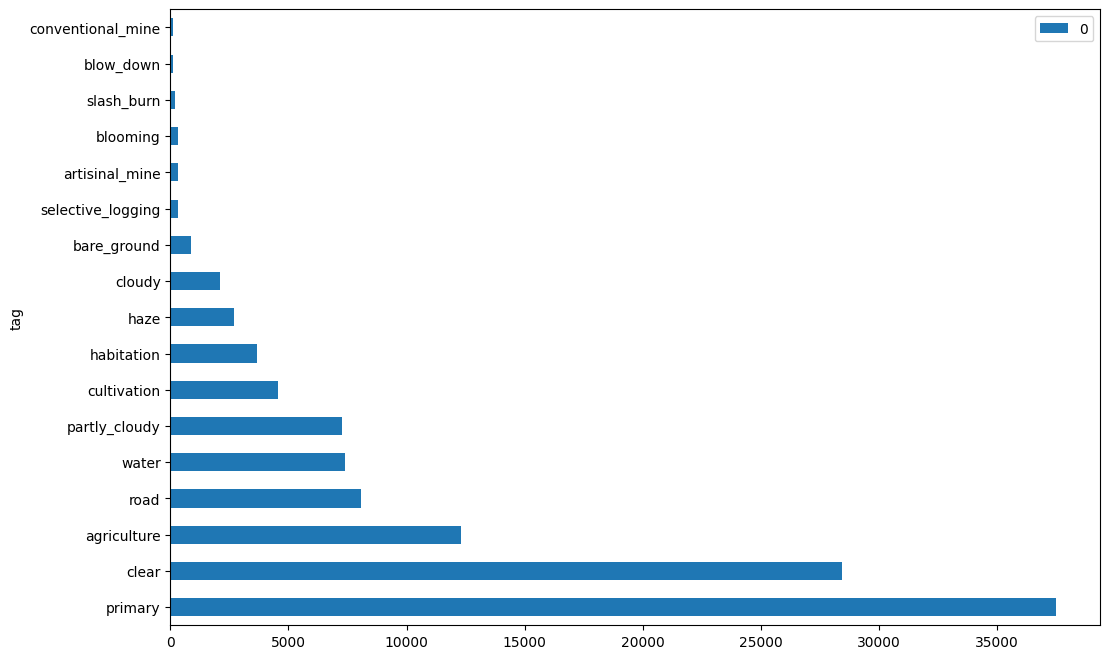

In [23]:
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

From this tag distribution it will most likely be relatively easy to predict the often occuring tags and comparatively very hard to get the low sampled tags correct.

# Submission from training tag counts

Let's do something fun. We'll take the training tag distribution and sample from it as a prior for our test data. For that we will configure a bernoulli distribution for each sample with the observed training frequency and sample from that for each test image. With that we'll generate a submission without ever looking at the images. :)

In [24]:
tag_probas = tags_counted_and_sorted[0].values/tags_counted_and_sorted[0].values.sum()
indicators = np.hstack([bernoulli.rvs(p, 0, sample.shape[0]).reshape(sample.shape[0], 1) for p in tag_probas])
indicators = np.array(indicators)
indicators.shape

(61191, 17)

In [25]:
indicators[:10,:]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
sorted_tags = tags_counted_and_sorted['tag'].values
all_test_tags = []
for index in range(indicators.shape[0]):
    all_test_tags.append(' '.join(list(sorted_tags[np.where(indicators[index, :] == 1)[0]])))
len(all_test_tags)

61191

In [27]:
sample['tags'] = all_test_tags
sample.head()
sample.to_csv('bernoulli_submission.csv', index=False)

Ok, enough for the fun part, lets get serious :).

# Looking at the actual images

In [30]:
from glob import glob
image_paths = sorted(glob('../../../../sherry/input/train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

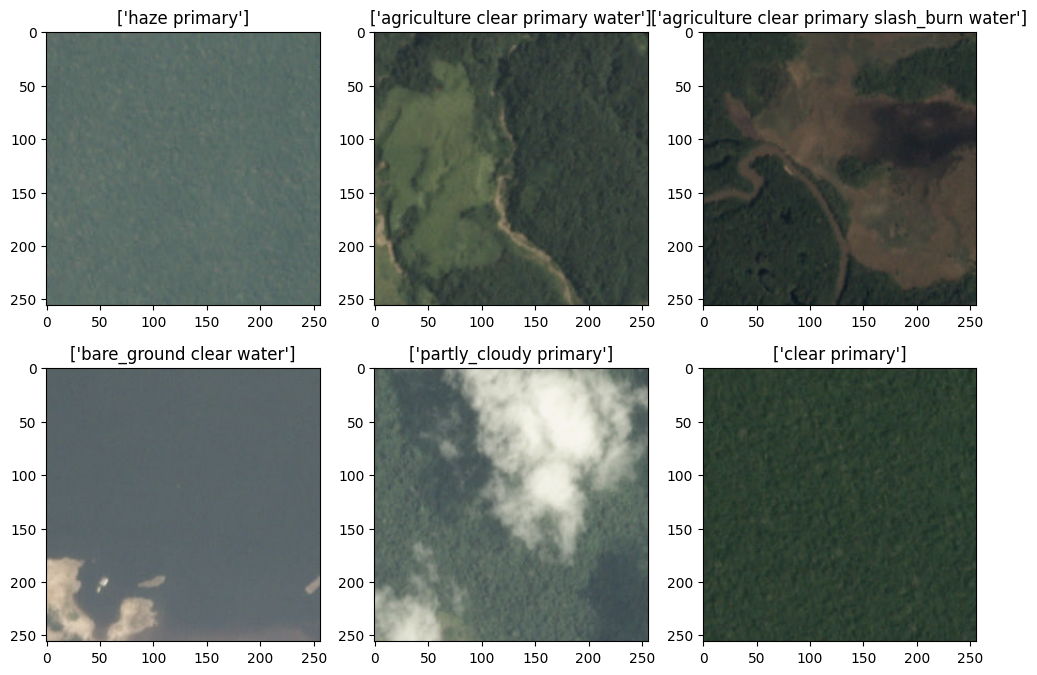

In [31]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))

It seems, that all of the images are of the same size, which would make preprocessing them much easier.

# Building multilabel models with the actual images

Now, we are going to build multilabel models in a classic OVR setting, where we train one model for each tag and that model is trained to distinguish between that tag and all the other tags.

There are a few things going on here:

* encoding of tags as multi label indicators
* flattening, encoding and scaling of images
* fitting OVR models
* evaluating F2 scores.

We are training the models on only a subset of samples to save runtime for the kernel and are rescaling the images quite heavily to 20x20x4 = 1600 dimensions.

In [33]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings

n_samples = 5000
rescaled_dim = 20

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]
X = np.squeeze(np.array([cv2.resize(plt.imread('../../../../sherry/input/train-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)

print(X.shape, y.shape, lb.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf.fit(X_train, y_train)

score = fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

(5000, 1600) (5000, 17) ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']
Average F2 test score 0.6849227365846277
F2 test scores per tag:


/Users/ulhaqi12/Desktop/junciton/.junciton/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[('primary', np.float64(0.9733022291342665)),
 ('clear', np.float64(0.8838426473071079)),
 ('cloudy', np.float64(0.5657894736842105)),
 ('agriculture', np.float64(0.3454384410983171)),
 ('road', np.float64(0.26875)),
 ('partly_cloudy', np.float64(0.16612641815235007)),
 ('water', np.float64(0.15914137675795706)),
 ('habitation', np.float64(0.14245014245014245)),
 ('blooming', np.float64(0.060240963855421686)),
 ('cultivation', np.float64(0.04076086956521739)),
 ('bare_ground', np.float64(0.027624309392265192)),
 ('haze', np.float64(0.019120458891013385)),
 ('slash_burn', np.float64(0.0)),
 ('conventional_mine', np.float64(0.0)),
 ('selective_logging', np.float64(0.0)),
 ('blow_down', np.float64(0.0)),
 ('artisinal_mine', np.float64(0.0))]

In [34]:
test_images_ = ['../../../../sherry/input/test-jpg/{}.jpg'.format(name) for name in sample['image_name'].values if name.startswith("test")]

In [36]:
X_sub = np.squeeze(np.array([cv2.resize(plt.imread('../../../../sherry/input/test-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in sample['image_name'].values if name.startswith("test")]))
X_sub = MinMaxScaler().fit_transform(X_sub)
X_sub.shape

(40669, 1600)

In [37]:
y_sub = clf.predict(X_sub)
all_test_tags = []
for index in range(y_sub.shape[0]):
    all_test_tags.append(' '.join(list(lb.classes_[np.where(y_sub[index, :] == 1)[0]])))
all_test_tags[0:20]

['clear primary',
 'clear primary',
 'clear habitation primary road water',
 'clear primary',
 'partly_cloudy primary road',
 'clear primary',
 'clear primary',
 'clear road',
 'clear primary',
 'primary',
 'clear primary road water',
 'agriculture clear primary',
 'cloudy partly_cloudy',
 'clear primary',
 'clear primary',
 'clear primary',
 'agriculture clear partly_cloudy primary',
 'clear primary',
 'clear primary',
 'clear primary']

In [38]:
test_imgs = [plt.imread('input/test-jpg/{}.jpg'.format(name)) for name in sample.head(20)['image_name'].values if name.startswith("test")]
plt.imshow(test_imgs[7])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ulhaqi12/Desktop/junciton/repo/echo/modeling/Forest-monitering/input/test-jpg/test_0.jpg'

In [ ]:
plt.imshow(test_imgs[3])
len(y_sub)

# [('primary', np.float64(0.9730363423212193)),
#  ('clear', np.float64(0.8820054017555705)),
#  ('cloudy', np.float64(0.5875576036866359)),
#  ('agriculture', np.float64(0.36356038445465944)),
#  ('road', np.float64(0.31699346405228757)),
#  ('partly_cloudy', np.float64(0.22071307300509338)),
#  ('water', np.float64(0.18054532056005895)),
#  ('habitation', np.float64(0.15151515151515152)),
#  ('bare_ground', np.float64(0.12195121951219512)),
#  ('cultivation', np.float64(0.07452574525745258)),
#  ('slash_burn', np.float64(0.0)),
#  ('conventional_mine', np.float64(0.0)),
#  ('haze', np.float64(0.0)),
#  ('selective_logging', np.float64(0.0)),
#  ('blow_down', np.float64(0.0)),
#  ('blooming', np.float64(0.0)),
#  ('artisinal_mine', np.float64(0.0))]

In [ ]:
sample = sample[:40669]

In [ ]:
sample['tags'] = all_test_tags
sample.head()

In [19]:
sample.to_csv('ovr_f2_{}.csv'.format(avg_sample_score), index=False)

In [1]:
import joblib

# Save the trained classifier
model_filename = "multilabel_logistic_regression.pkl"
joblib.dump(clf, model_filename)
print(f"Model saved as {model_filename}")

NameError: name 'clf' is not defined

# Image clustering

Without having to look at all of the images, a common technique is to cluster images by their native representation (pixel intensities) or some encoded version of it, e.g. by computing activations of a vision-based neural network.

For our purpose we will just use the pixel intensities and compute pairwise distances.

In [20]:
import cv2

n_imgs = 600

all_imgs = []

for i in range(n_imgs):
    img = plt.imread(image_paths[i])
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    all_imgs.append(img)

img_mat = np.vstack(all_imgs)
img_mat.shape

(600, 40000)

We can see frmo the line spectrum in the clustermap, that there are a few images that are very **dissimilar** to all other images by using the pixel intensities.

Also there is a block-like structure to it, maybe that already tells us something about the tags themselves.

(600, 600)


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


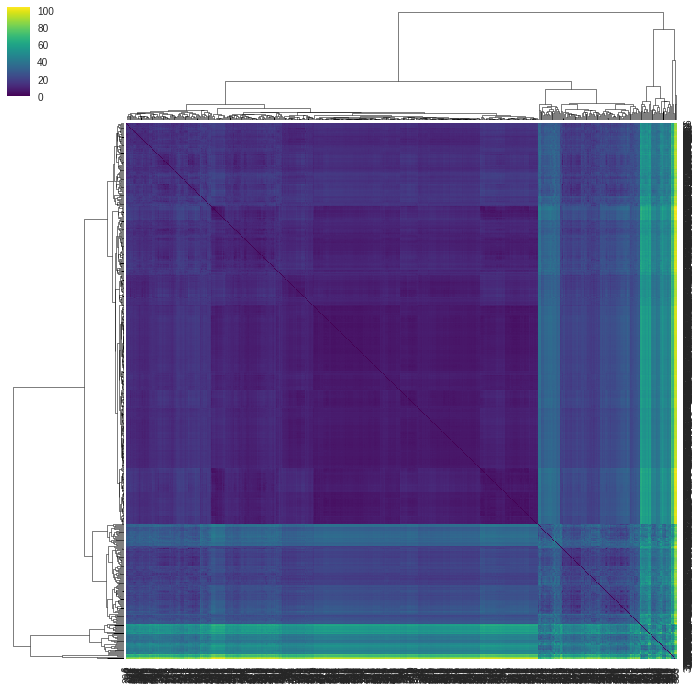

In [21]:
from scipy.spatial.distance import pdist, squareform

sq_dists = squareform(pdist(img_mat))
print(sq_dists.shape)
sns.clustermap(
    sq_dists,
    figsize=(12,12),
    cmap=plt.get_cmap('viridis')
)

Let's have a look at t-SNE embedding of the images to get a nice visualization of the distances in three dimensions.
It looks like there are a few outliers, which we already suspected from the clustermap view above. Other than that, the 3d embedding doesn't tell us much.

In [22]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_mat)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 2.026685
[t-SNE] Iteration 25: error = 0.9390960, gradient norm = 0.0111131
[t-SNE] Iteration 50: error = 0.8599207, gradient norm = 0.0122872
[t-SNE] Iteration 75: error = 0.5703945, gradient norm = 0.0027242
[t-SNE] Iteration 100: error = 0.4607736, gradient norm = 0.0011157
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.460774
[t-SNE] Iteration 125: error = 0.3635061, gradient norm = 0.0006994
[t-SNE] Iteration 125: gradient norm 0.000699. Finished.
[t-SNE] Error after 125 iterations: 0.363506


In [24]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        #color = preprocessing.LabelEncoder().fit_transform(all_image_types),
        #colorscale = 'Portland',
        #colorbar = dict(title = 'images'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.9
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3D embedding of images')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Tracking down outliers

Let's try to find the **most common image**, as indicated by the average distance to all other images and the **least common image** by the same metric.

As we expected, the image that has least distance to all others is an image with rainforest on it. The image with the maximal average distance to all others shows only clouds and seems to be a little overexposed.

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning:

Mean of empty slice



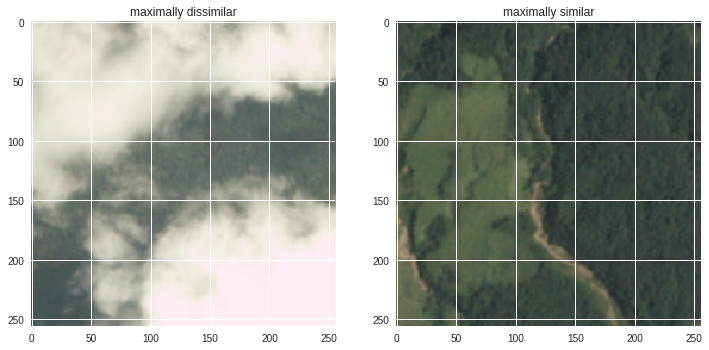

In [25]:
mask = np.zeros_like(sq_dists, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# upper triangle of matrix set to np.nan
sq_dists[np.triu_indices_from(mask)] = np.nan
sq_dists[0, 0] = np.nan

fig = plt.figure(figsize=(12,8))
# maximally dissimilar image
ax = fig.add_subplot(1,2,1)
maximally_dissimilar_image_idx = np.nanargmax(np.nanmean(sq_dists, axis=1))
plt.imshow(plt.imread(image_paths[maximally_dissimilar_image_idx]))
plt.title('maximally dissimilar')

# maximally similar image
ax = fig.add_subplot(1,2,2)
maximally_similar_image_idx = np.nanargmin(np.nanmean(sq_dists, axis=1))
plt.imshow(plt.imread(image_paths[maximally_similar_image_idx]))
plt.title('maximally similar')

# # now compute the mean image
#ax = fig.add_subplot(1,3,3)
#mean_img = gray_imgs_mat.mean(axis=0).reshape(rescaled_dim, rescaled_dim, 3)
#plt.imshow(cv2.normalize(mean_img, None, 0.0, 1.0, cv2.NORM_MINMAX))
#plt.title('mean image')

## Image scatter plot

This scatter plot shows a 2D embedding but with the actual images overlaid.

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_mat)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 2.026685
[t-SNE] Iteration 25: error = 1.1261289, gradient norm = 0.0202719
[t-SNE] Iteration 50: error = 1.0853636, gradient norm = 0.0191239
[t-SNE] Iteration 75: error = 0.7881593, gradient norm = 0.0125069
[t-SNE] Iteration 100: error = 0.8264055, gradient norm = 0.0118255
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.826405
[t-SNE] Iteration 125: error = 0.7060739, gradient norm = 0.0049483
[t-SNE] Iteration 150: error = 0.7192265, gradient norm = 0.0054577
[t-SNE] Iteration 175: error = 0.7271838, gradient norm = 0.0065029
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.727184


There is the large chunk of pure rainforest images that is present in the data. The tag distribution already hinted in that direction earlier.

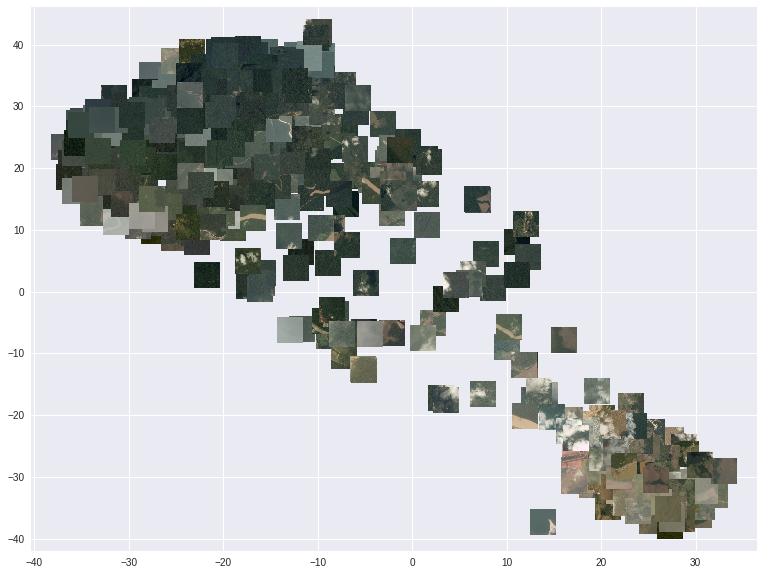

In [27]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

nimgs = 500
plt.figure(figsize=(13,10))
imscatter(tsne[0:nimgs,0], tsne[0:nimgs,1], [plt.imread(image_paths[i]) for i in range(nimgs)])

# GeoTiff Images

In remote sensing a standard measure to use for determining whether there is vegetation present is [NDVI][1], the "Normalized Difference Vegetation Index". There are several weak points to the original index and some extensions of it.

We're now going to compute the NDVI for a few images and rank them by it to see how well we can identify the amount of vegetation in the image.

  [1]: https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index

In [28]:
from skimage import io
image_paths = sorted(glob('../input/train-tif/*.tif'))[0:1000]
imgs = [io.imread(path) / io.imread(path).max() for path in image_paths]
#r, g, b, nir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
ndvis = [(img[:,:,3] - img[:,:,0])/((img[:,:,3] + img[:,:,0])) for img in imgs]

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning:

invalid value encountered in true_divide



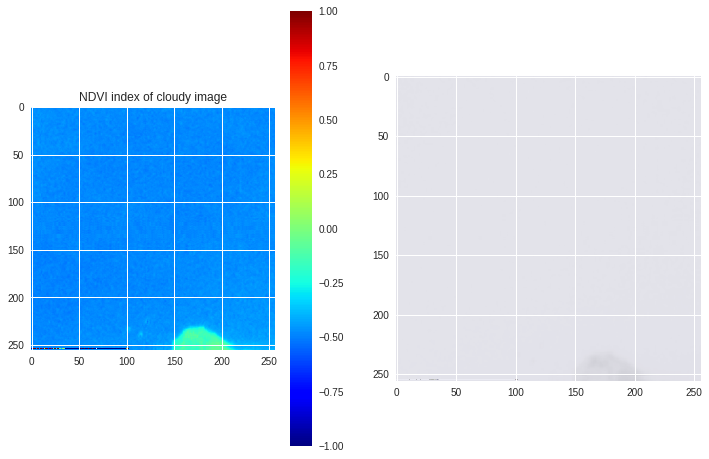

In [29]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(ndvis[32], cmap='jet')
plt.colorbar()
plt.title('NDVI index of cloudy image')
plt.subplot(122)
plt.imshow(imgs[32])

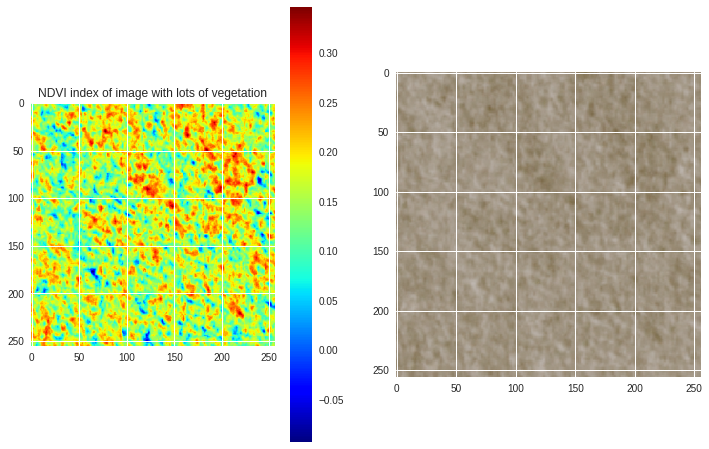

In [30]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(ndvis[10], cmap='jet')
plt.colorbar()
plt.title('NDVI index of image with lots of vegetation')
plt.subplot(122)
plt.imshow(imgs[10])

The mean NDVI distribution has its mode around 0.2, which is not unexpected because a lot of images show actually trees. 

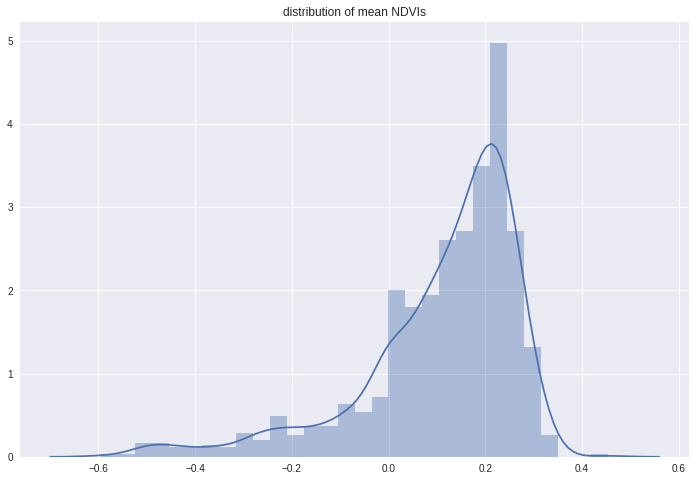

In [31]:
import seaborn as sns
mndvis = np.nan_to_num([ndvi.mean() for ndvi in ndvis])
plt.figure(figsize=(12,8))
sns.distplot(mndvis)
plt.title('distribution of mean NDVIs')

# NDVI ranking of images

Let's plot a few images which have very low and very high NDVI values.

1000


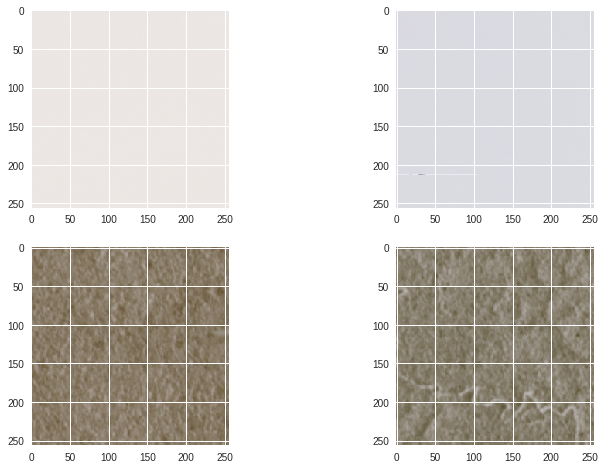

In [32]:
sorted_idcs = np.argsort(mndvis)
print(len(sorted_idcs))
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(imgs[sorted_idcs[0]])
plt.subplot(222)
plt.imshow(imgs[sorted_idcs[50]])
plt.subplot(223)
plt.imshow(imgs[sorted_idcs[-30]])
plt.subplot(224)
plt.imshow(imgs[sorted_idcs[-11]])

Median NDVI value image can also be interesting to look at, it actually shows a mix of vegetation and roads.

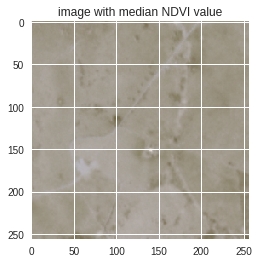

In [33]:
plt.imshow(imgs[sorted_idcs[500]])
plt.title('image with median NDVI value')